Размер исходного изображения: 23789568 байт
Размер сжатых данных: 19729440 байт
Коэффициент сжатия: 1.21:1
Экономия памяти: 17.07%


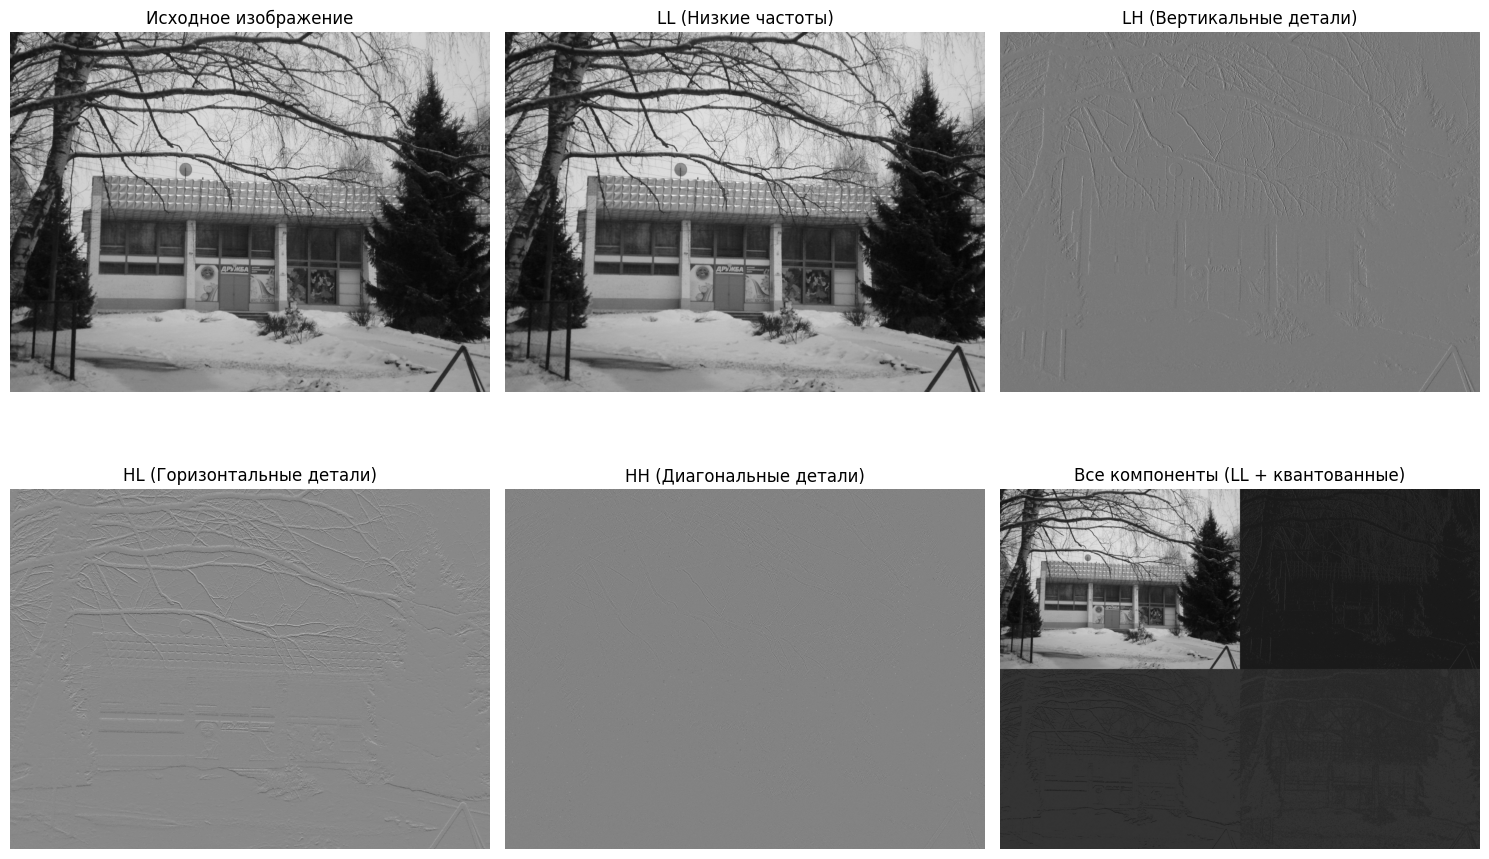

In [3]:
import numpy as np
import cv2
from collections import Counter
original_image = cv2.imread('image.png', cv2.IMREAD_GRAYSCALE)

height, width = original_image.shape
if height % 2 != 0:
    original_image = original_image[:height-1, :]
if width % 2 != 0:
    original_image = original_image[:, :width-1]

original_image = original_image.astype(np.float32)
np.savetxt('original_image_data.txt', original_image, fmt='%d')

def haar_wavelet_transform(image):
    rows, cols = image.shape
    row_transform = np.zeros_like(image, dtype=np.float32)
    for i in range(rows):
        for j in range(0, cols - 1, 2):
            row_transform[i, j // 2] = (image[i, j] + image[i, j + 1]) / np.sqrt(2)
            row_transform[i, (j // 2) + cols // 2] = (image[i, j] - image[i, j + 1]) / np.sqrt(2)
    result = np.zeros_like(row_transform, dtype=np.float32)
    for j in range(cols):
        for i in range(0, rows - 1, 2):
            result[i // 2, j] = (row_transform[i, j] + row_transform[i + 1, j]) / np.sqrt(2)
            result[(i // 2) + rows // 2, j] = (row_transform[i, j] - row_transform[i + 1, j]) / np.sqrt(2)
    LL = result[:rows // 2, :cols // 2] 
    LH = result[:rows // 2, cols // 2:]  
    HL = result[rows // 2:, :cols // 2]   
    HH = result[rows // 2:, cols // 2:] 
    return LL, LH, HL, HH
    
LL_component, LH_component, HL_component, HH_component = haar_wavelet_transform(original_image)
quantization_levels = 4

def quantize_coefficients(coeffs, levels):
    min_val = np.min(coeffs)
    max_val = np.max(coeffs)
    step = (max_val - min_val) / levels
    quantized = np.floor((coeffs - min_val) / step).astype(int)
    return quantized, min_val, step

LH_quantized, LH_min, LH_step = quantize_coefficients(LH_component, quantization_levels)
HL_quantized, HL_min, HL_step = quantize_coefficients(HL_component, quantization_levels)
HH_quantized, HH_min, HH_step = quantize_coefficients(HH_component, quantization_levels)

def run_length_encode(data):
    flattened = data.flatten()
    encoded = []
    current_value = flattened[0]
    count = 1
    
    for i in range(1, len(flattened)):
        if flattened[i] == current_value:
            count += 1
        else:
            encoded.append((int(current_value), int(count)))
            current_value = flattened[i]
            count = 1
    encoded.append((int(current_value), int(count)))
    
    return encoded

LH_encoded = run_length_encode(LH_quantized)
HL_encoded = run_length_encode(HL_quantized)
HH_encoded = run_length_encode(HH_quantized)

with open('wavelet_compressed_data.txt', 'w') as f:
    f.write("LL Component:\n")
    np.savetxt(f, LL_component, fmt='%.6f')
    
    f.write("\nLH Component (RLE encoded):\n")
    for value, count in LH_encoded:
        f.write(f"{value} {count}\n")
    
    f.write("\nHL Component (RLE encoded):\n")
    for value, count in HL_encoded:
        f.write(f"{value} {count}\n")
    
    f.write("\nHH Component (RLE encoded):\n")
    for value, count in HH_encoded:
        f.write(f"{value} {count}\n")

    f.write("\nQuantization Parameters:\n")
    f.write(f"LH: min={LH_min:.6f}, step={LH_step:.6f}\n")
    f.write(f"HL: min={HL_min:.6f}, step={HL_step:.6f}\n")
    f.write(f"HH: min={HH_min:.6f}, step={HH_step:.6f}\n")

original_size = original_image.nbytes
compressed_size = 0

with open('wavelet_compressed_data.txt', 'r') as f:
    compressed_size = len(f.read().encode('utf-8'))

compression_ratio = original_size / compressed_size
space_saving = (1 - compressed_size / original_size) * 100

print(f"Размер исходного изображения: {original_size} байт")
print(f"Размер сжатых данных: {compressed_size} байт")
print(f"Коэффициент сжатия: {compression_ratio:.2f}:1")
print(f"Экономия памяти: {space_saving:.2f}%")

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(LL_component, cmap='gray')
plt.title('LL (Низкие частоты)')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(LH_component, cmap='gray')
plt.title('LH (Вертикальные детали)')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(HL_component, cmap='gray')
plt.title('HL (Горизонтальные детали)')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(HH_component, cmap='gray')
plt.title('HH (Диагональные детали)')
plt.axis('off')

plt.subplot(2, 3, 6)
combined_quantized = np.zeros_like(original_image)
h, w = LL_component.shape
combined_quantized[:h, :w] = LL_component
combined_quantized[:h, w:] = LH_quantized * 50 
combined_quantized[h:, :w] = HL_quantized * 50
combined_quantized[h:, w:] = HH_quantized * 50
plt.imshow(combined_quantized, cmap='gray')
plt.title('Все компоненты (LL + квантованные)')
plt.axis('off')

plt.tight_layout()
plt.show()